## Librairies Importation

In [1]:
# --- Core libraries ---
import numpy as np  # For numerical operations and array manipulation
import random  # For generating random numbers and random selections
import pandas as pd  # For data manipulation and analysis
import pickle  # For serializing and deserializing objects (e.g., saving models)

# --- Image processing libraries ---
from PIL import Image  # For opening, manipulating, and saving images (basic image I/O)
import cv2  # OpenCV: powerful library for advanced image and video processing
from skimage.color import rgb2gray  # For converting RGB images to grayscale
from skimage.feature import canny  # For Canny edge detection
from skimage.measure import shannon_entropy  # For measuring image complexity (entropy)
from skimage.transform import resize  # For resizing images
from skimage.exposure import histogram  # For computing image histograms
from skimage.util import img_as_float  # For converting images to float format
from scipy.ndimage import laplace  # For applying the Laplace operator (e.g., edge/blurriness detection)

# --- Statistical and machine learning libraries ---
from sklearn.decomposition import PCA  # For principal component analysis (PCA)
from sklearn.ensemble import RandomForestClassifier  # For random forest classification
from scipy.stats import skew, kurtosis, entropy  # For statistical analysis (skewness, kurtosis, entropy)

# --- Visualization ---
import matplotlib.pyplot as plt  # For displaying images and plotting data
import seaborn as sns  # For statistical data visualization (based on matplotlib)


## Load data

In [2]:

# Load the training images and labels back from the saved NumPy files
train_images = np.load('/shared/data/train_images.npy')  # Load image training data
train_labels = np.load('/shared/data/train_labels.npy')  # Load label training data
val_images = np.load('/shared/data/val_images.npy')  # Load image training data
val_labels = np.load('/shared/data/val_labels.npy')  # Load label training data

print("Training Data loaded successfully from NumPy files.")

Training Data loaded successfully from NumPy files.


In [3]:
#shape of data 
# Print basic information about each dataset
print(f"Training images: {train_images.shape}, Training labels: {train_labels.shape}")
print(f"Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")


Training images: (9711, 512, 512, 3), Training labels: (9711,)
Validation images: (3237, 512, 512, 3), Validation labels: (3237,)


### Visualisation

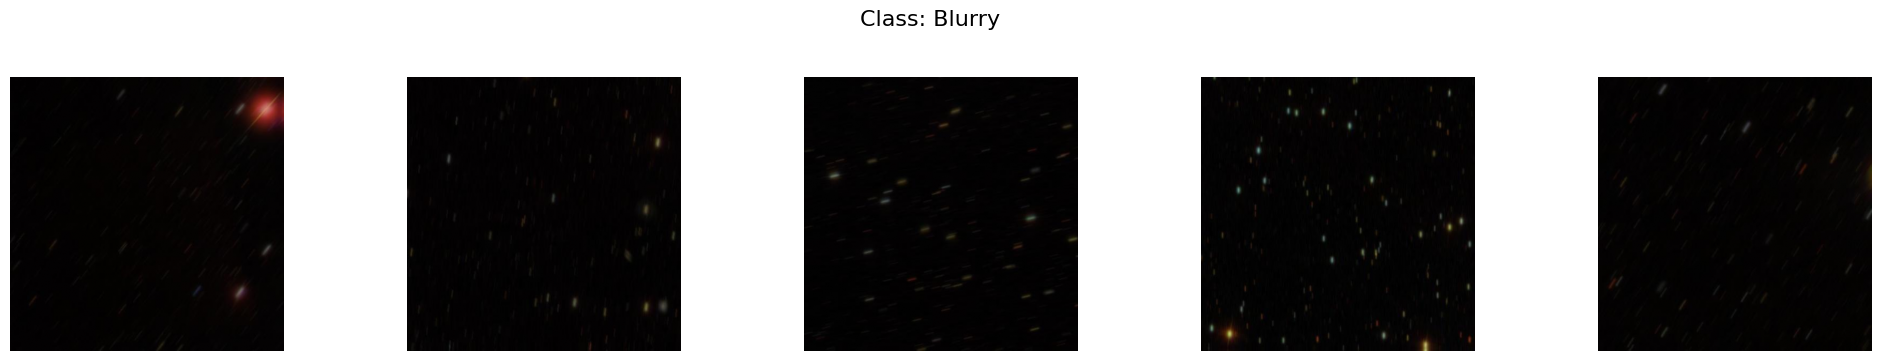

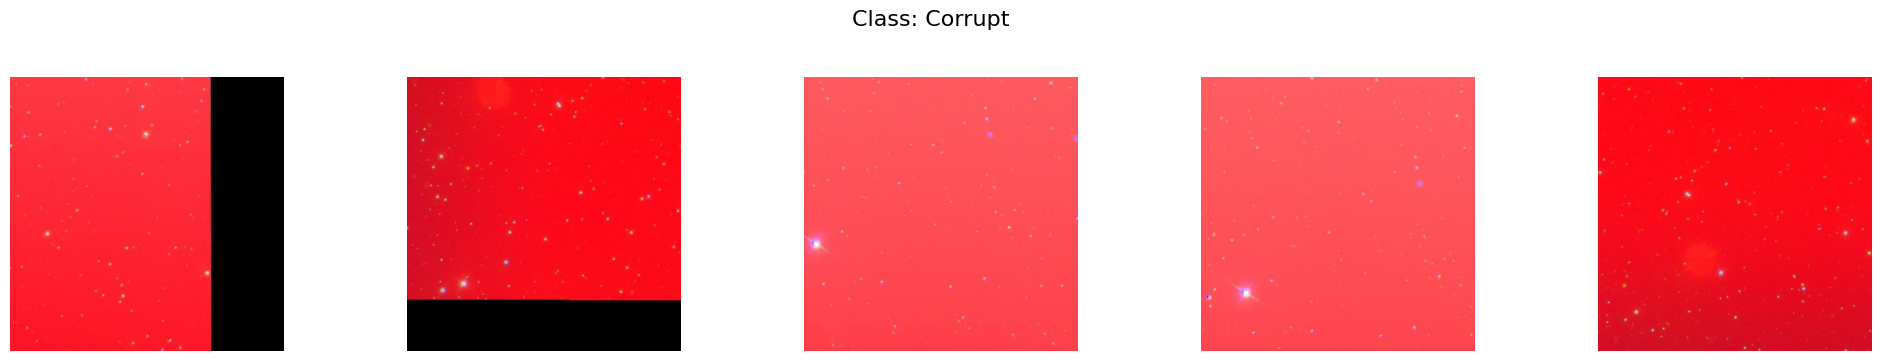

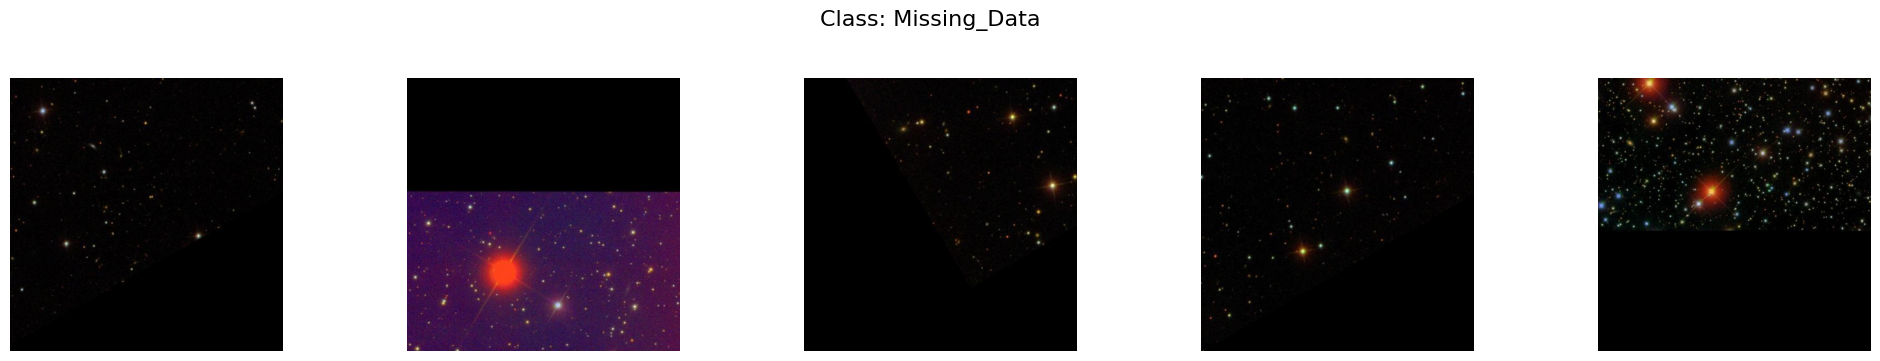

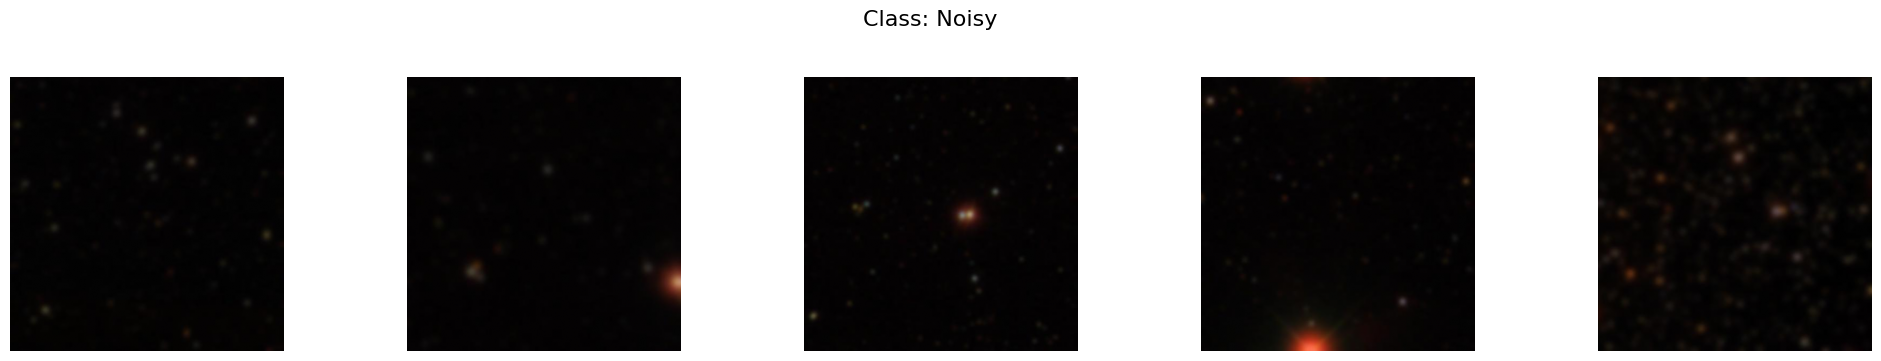

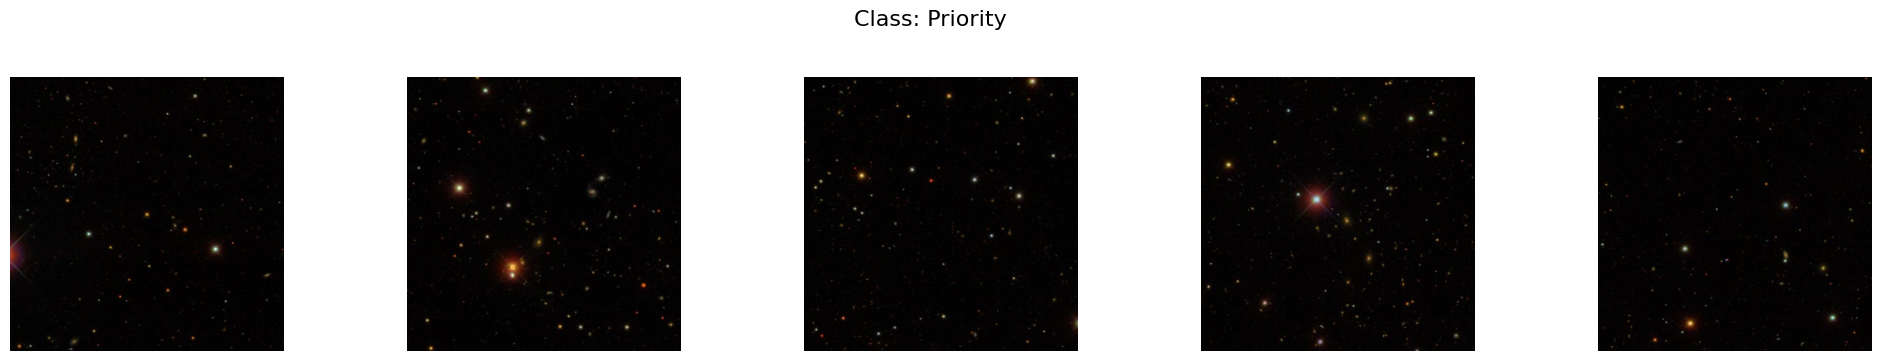

In [4]:
# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Get the unique labels in the training set
unique_labels = np.unique(train_labels)


# Display the first 5 images for each class
for label in unique_labels:
    # Find the indices of images belonging to the current class
    class_indices = np.where(train_labels == label)[0]
    
    # Select the first 5 images of this class
    num_images_to_display = min(5, len(class_indices))
    selected_indices = class_indices[:num_images_to_display]
    selected_images = train_images[selected_indices] / 255.0  # Normalize images for better visualization

    # Plot the selected images
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
    fig.suptitle(f'Class: {class_names[label]}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i])
        ax.axis('off')
    
    plt.show()
    print()

## Preprocessing

In [5]:
def preprocess_image(img):
    """
    Takes an image (numpy array) already loaded in grayscale 
    and returns a feature vector.
    """

    # 1. Check if the image is in color, convert it to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Resize to 128x128
    img = cv2.resize(img, (128, 128))

    # 3. Blur (variance of the Laplacian)
    blur = cv2.Laplacian(img, cv2.CV_64F).var()

    # 4. Percentage of black pixels (missing_data)
    black_ratio = (img < 5).sum() / img.size

    # 5. Mean intensity
    mean_intensity = np.mean(img)

    # 6. Standard deviation of intensity
    std_intensity = np.std(img)

    # 7. Skewness
    skewness = skew(img.flatten())

    # 8. Kurtosis
    kurt = kurtosis(img.flatten())

    # 9. Entropy (disorder)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    ent = entropy(hist_norm + 1e-7)

    # 10. Edge-related features
    # Using the Canny edge detector
    edges = cv2.Canny(img, 30, 100)  

    # a) Percentage of edge pixels
    edge_ratio = np.sum(edges > 0) / edges.size

    return [blur, black_ratio, mean_intensity, std_intensity, skewness, kurt, ent, edge_ratio]

def preprocess_dataset(image_list):
    return [preprocess_image(img) for img in image_list]


In [6]:
train_images_pre = preprocess_dataset(train_images)
val_images_pre = preprocess_dataset(val_images)

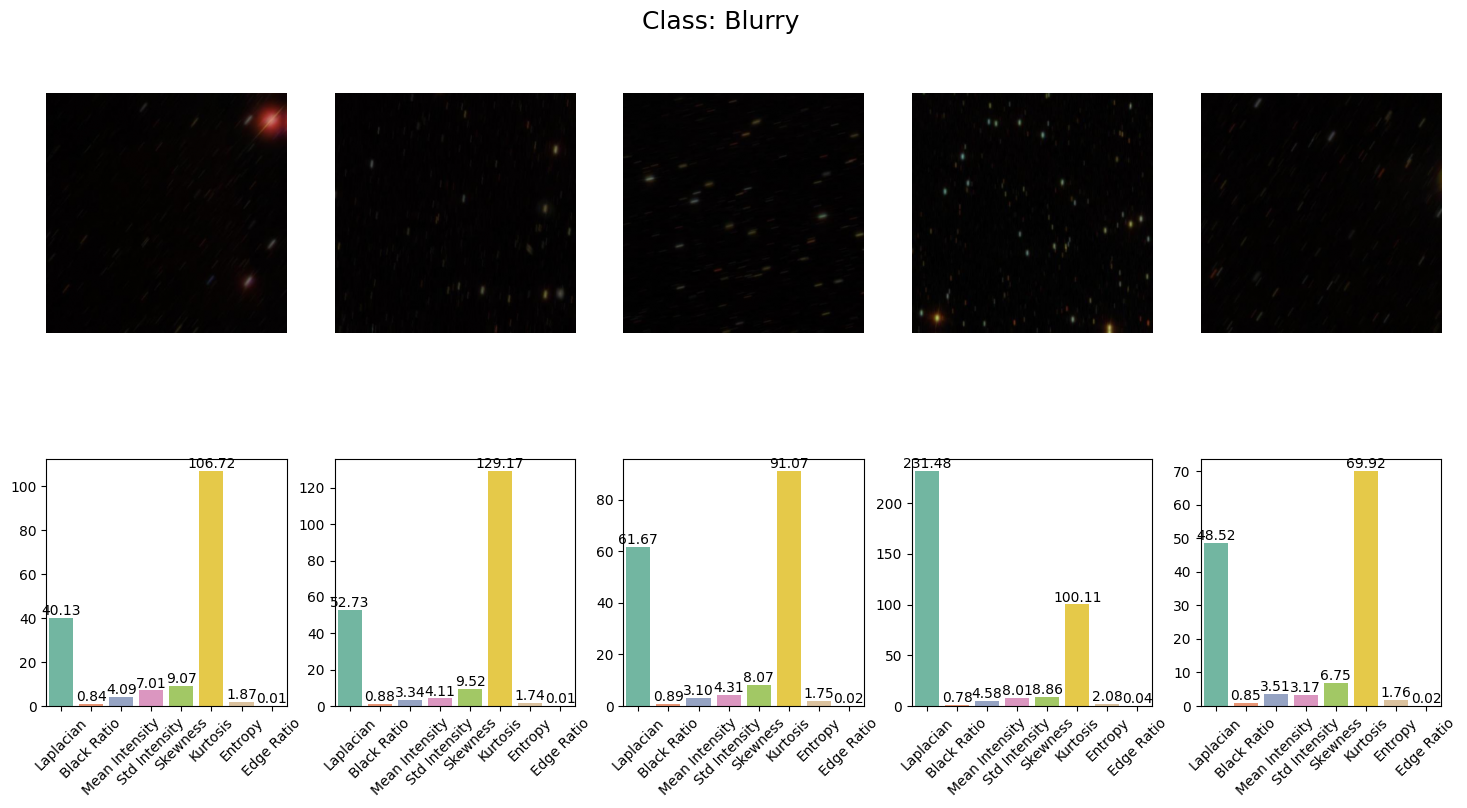

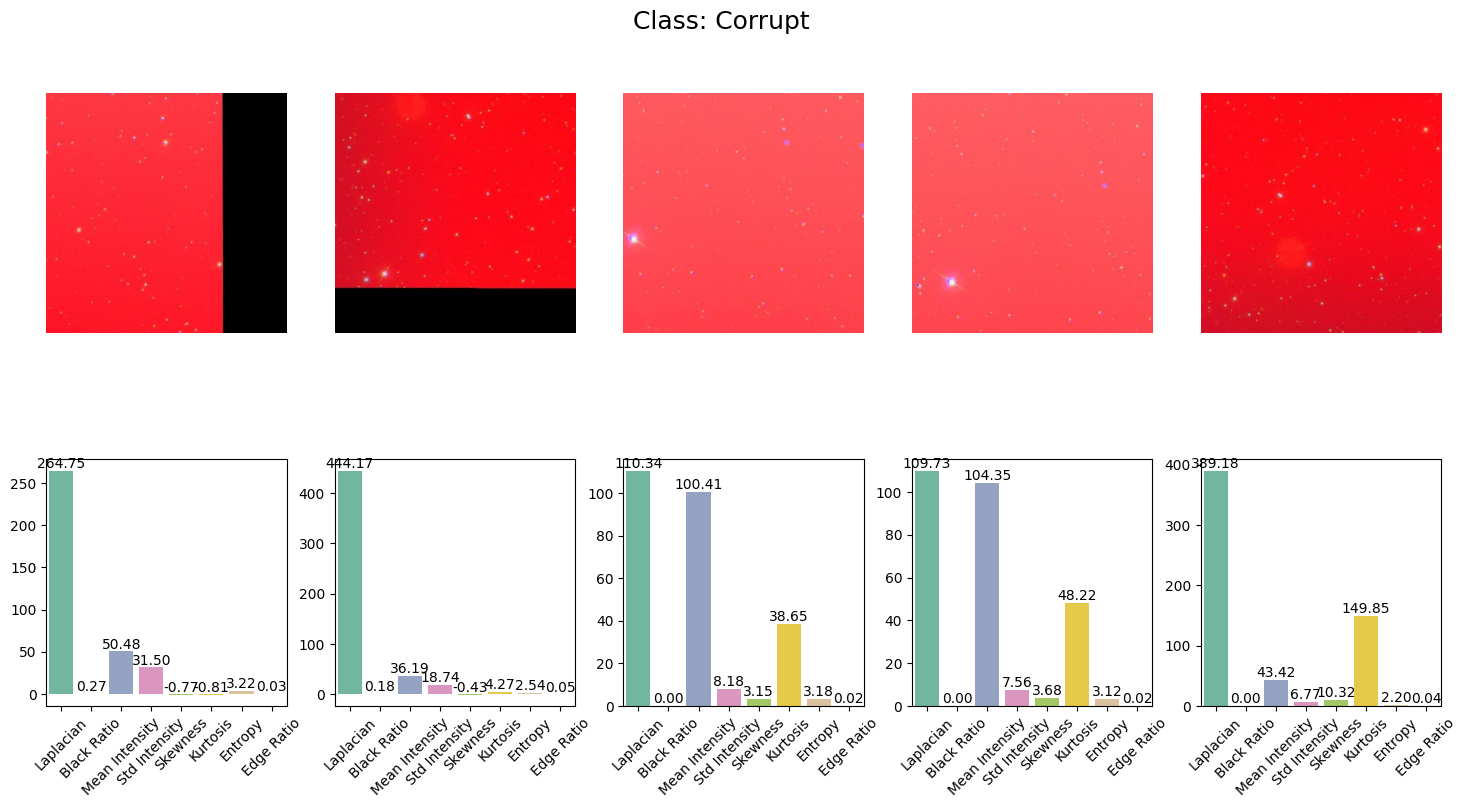

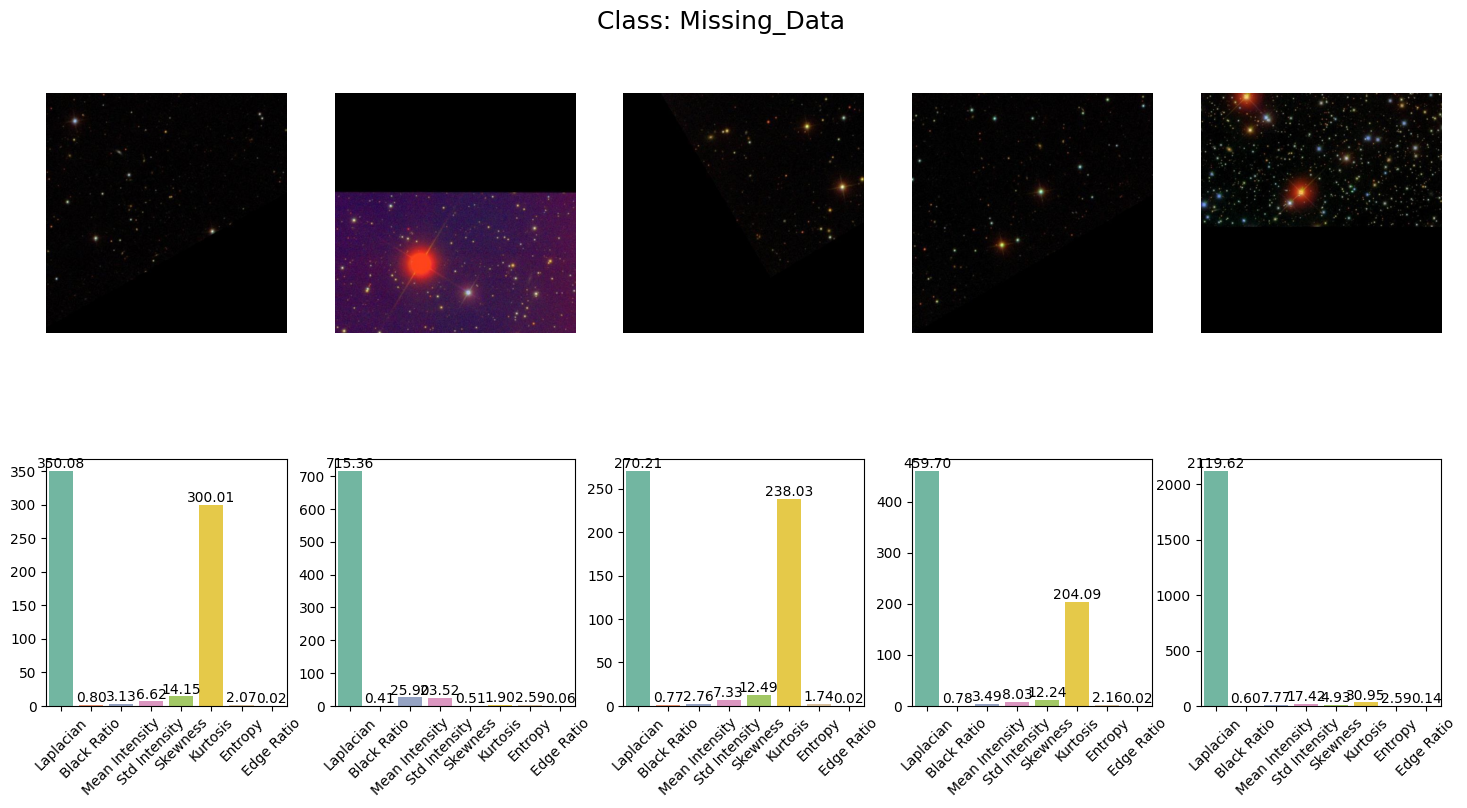

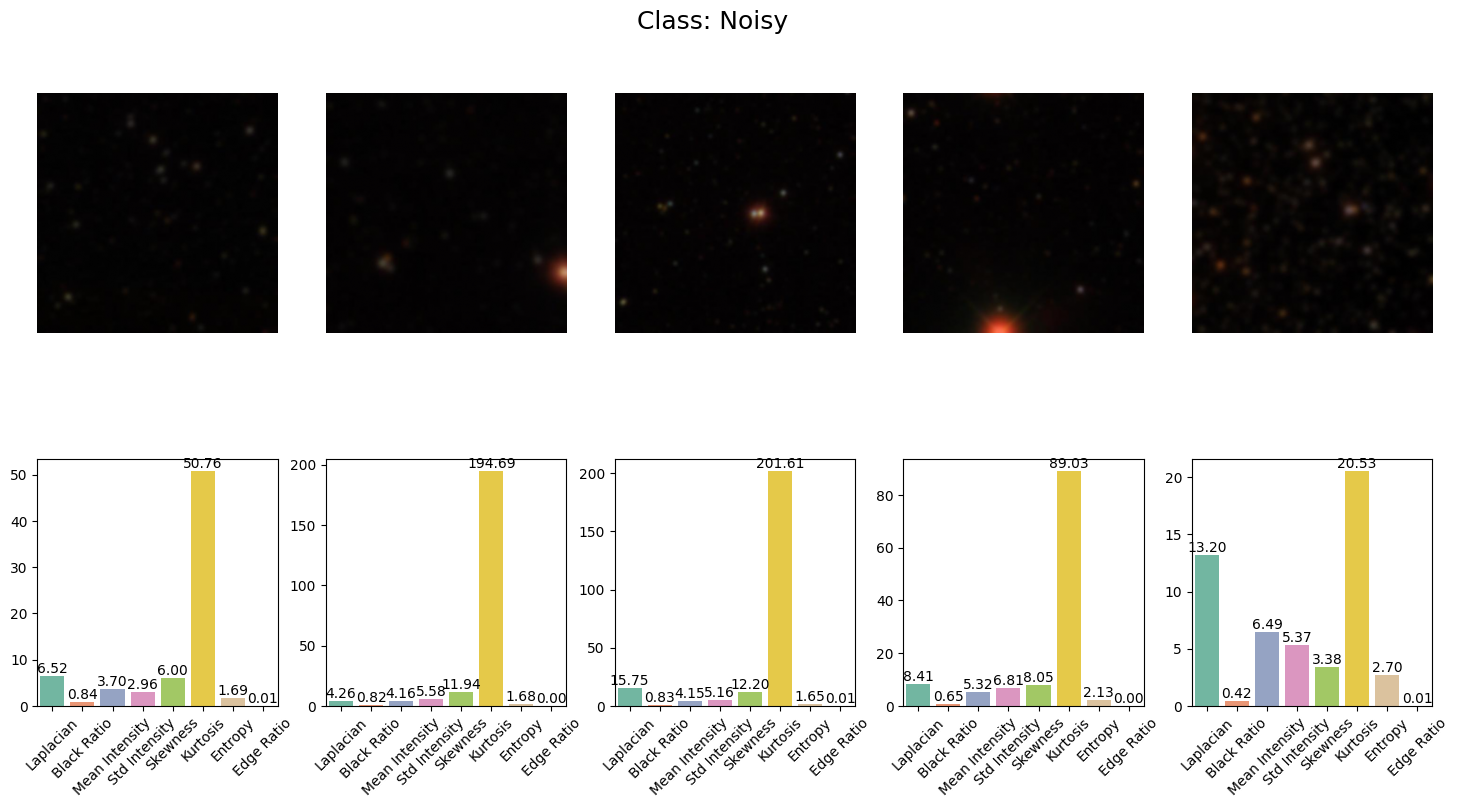

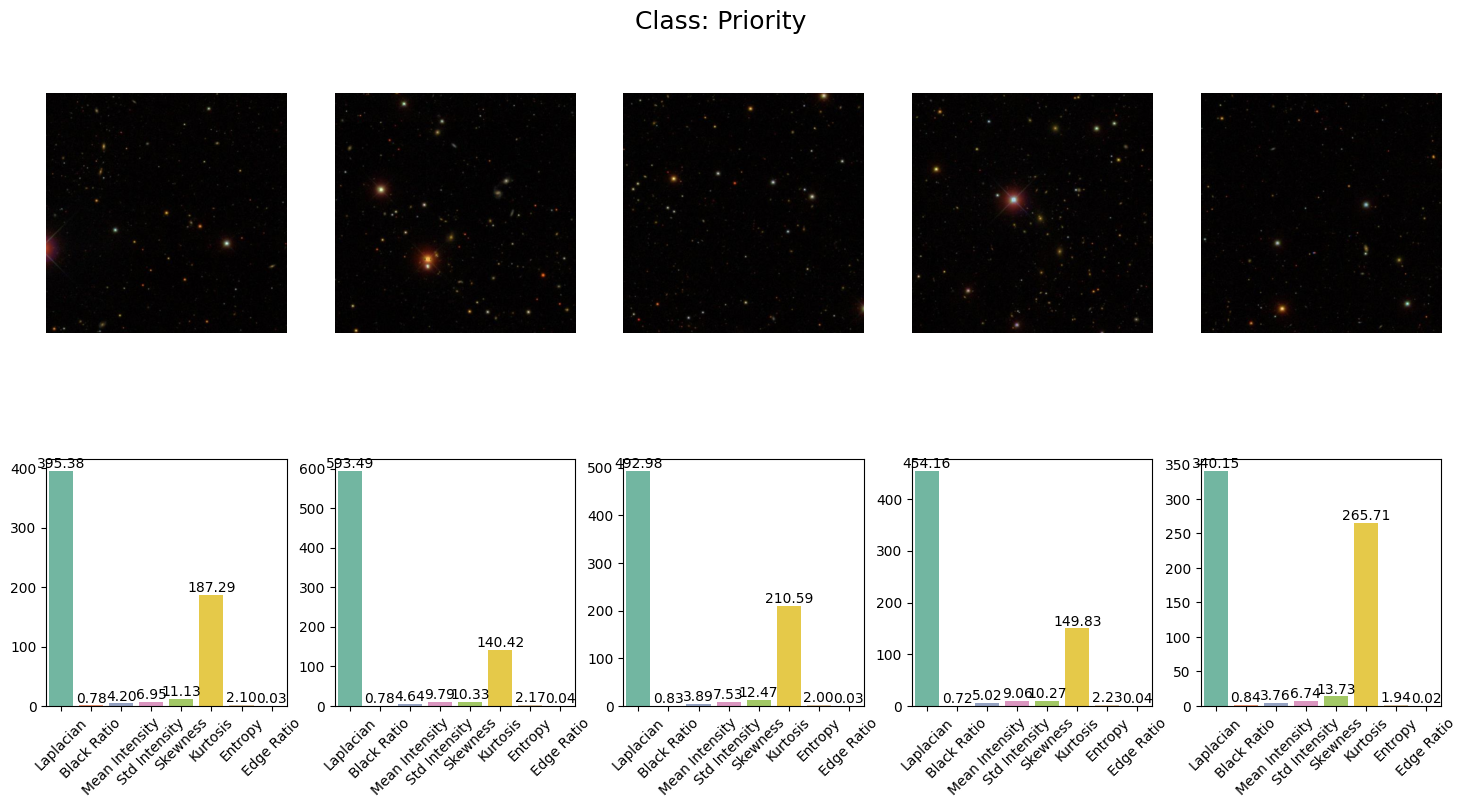

In [7]:
# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Get the unique labels in the training set
unique_labels = np.unique(train_labels)

# Display the first 5 images for each class
for label in unique_labels:
    # Find the indices of images belonging to the current class
    class_indices = np.where(train_labels == label)[0]
    
    # Select the first 5 images of this class
    num_images_to_display = min(5, len(class_indices))
    selected_indices = class_indices[:num_images_to_display]
    selected_images = train_images[selected_indices] / 255.0  # Normalize images for better visualization

    # Plot the selected images and their features
    fig, axes = plt.subplots(2, num_images_to_display, figsize=(18, 8))  # Increased figsize for larger subplots
    fig.suptitle(f'Class: {class_names[label]}', fontsize=18)

    # Plot images and their corresponding features
    for i, ax in enumerate(axes[0]):  # First row for images
        ax.imshow(selected_images[i])
        ax.axis('off')
        
        # Extract features for the current image
        img = selected_images[i] * 255  # Convert back to original pixel scale for processing (if needed)
        img = img.astype(np.uint8)  # Ensure it's uint8 for OpenCV compatibility
        features = preprocess_image(img)  # Extract features
        
        # Convert features to a DataFrame for easier plotting
        feature_names = ['Laplacian', 'Black Ratio', 'Mean Intensity', 'Std Intensity', 'Skewness', 'Kurtosis', 'Entropy','Edge Ratio']
        df_features = pd.DataFrame([features], columns=feature_names)
        
        # Plot the feature values below the corresponding image (second row)
        df_melted = pd.melt(df_features, var_name='Feature', value_name='Value')
        sns.barplot(x='Feature', y='Value', data=df_melted, hue='Feature', palette="Set2", ax=axes[1, i], dodge=False)
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')
        
        # Set fixed tick positions and labels for the bar plots
        axes[1, i].set_xticks(np.arange(len(df_melted['Feature'])))  # Set ticks for each feature
        axes[1, i].set_xticklabels(df_melted['Feature'], rotation=45, fontsize=10)  # Reduced font size for column names
        
        # Annotate the bars with their feature values below the bars
        for j, v in enumerate(df_melted['Value']):
            axes[1, i].text(j, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10, color='black')

    plt.subplots_adjust(hspace=0.5)  # Increased vertical space to avoid crowding
    plt.show() 


#### Interpretation

* Blur: Measures image sharpness; low variance indicates a blurry image.

* Black Pixel Ratio: Indicates missing or corrupted data based on the percentage of black pixels.

* Mean Intensity : Represents the overall brightness of the image.

* Standard Deviation of Intensity : Shows the image's contrast; higher values indicate more contrast.

* Skewness : Measures asymmetry in the pixel intensity distribution.

* Kurtosis : Assesses the "tailedness" of the intensity distribution, indicating how much extreme variation exists.

* Entropy: Quantifies image disorder; higher entropy indicates more complexity.

* Edge Ratio: Percentage of edge pixels, revealing image detail and structure.

**Noisy Images**: High entropy and standard deviation, low edge ratio, and skewed intensity distribution due to random pixel variations.

**Corrupt Images**: High blur, inconsistent mean intensity, high black pixel ratio, and high entropy, often indicating missing or distorted parts.

**Missing Data**: High black pixel ratio, low mean intensity, low entropy, and low edge ratio, reflecting large missing or blacked-out areas.

**Priority**: Balanced mean intensity, moderate blur and entropy, and a higher edge ratio, indicating sharp, clear, and well-exposed images.

#### Freeing up space

In [8]:
import gc

# Since we will no longer need the original data, we can remove it from memory
del train_images, val_images


# Force garbage collection to free up memory
gc.collect()

print("Original images removed from memory.")

Original images removed from memory.


### Interpretation

1. Blur - Laplacian Variance
Blur is measured by calculating the Laplacian variance of the image, which gives an indication of the image's sharpness.

Calculation: cv2.Laplacian(img, cv2.CV_64F).var()

The Laplacian is a method used to detect edges in an image. A higher blur results in lower variance.

The variance is a measure of the dispersion of pixels after applying the Laplacian. The lower the variance, the blurrier the image is.

Interpretation: Blur is proportional to the amount of detail in the image. The lower the variance, the blurrier the image.

2. Black Pixel Ratio (missing_data)
This measures the proportion of pixels in the image that are close to zero intensity (i.e., black or nearly black).

Calculation: (img < 10).sum() / img.size

The expression img < 10 creates a binary mask where each pixel with a value below 10 is considered black.

The ratio of black pixels is then computed relative to the total number of pixels in the image.

Interpretation: This gives an idea of the amount of black pixels in the image, which can indicate the presence of dark areas or missing data.

3. Mean Intensity
This is simply the mean of the pixel intensities in the image.

Calculation: np.mean(img)

It calculates the mean of the pixel values in the image.

Interpretation: The mean intensity gives a measure of the overall brightness of the image. A brighter image will have a higher mean, and a darker image will have a lower mean.

4. Standard Deviation of Intensity
The standard deviation measures the dispersion of pixel values around the mean intensity.

Calculation: np.std(img)

This calculates the standard deviation of the pixel values, indicating how spread out the pixel intensities are.

Interpretation: The standard deviation is an indicator of the variability in the image. An image with a lot of variation (e.g., many edges or textures) will have a higher standard deviation. A uniform image will have a low standard deviation.

5. Skewness
Skewness measures the asymmetry of the distribution of pixel intensities in the image.

Calculation: skew(img.flatten())

The image is flattened into a 1D vector using img.flatten(), and then skewness is calculated for this distribution.

Interpretation: Skewness indicates whether the pixel intensity is concentrated more on the darker (left) or lighter (right) side of the distribution. A positive skew means the image has brighter areas, and a negative skew means the image is darker.

6. Kurtosis
Kurtosis measures the "height" of the peaks in the distribution of pixel intensities. High kurtosis means a sharper peak, while low kurtosis indicates a flatter distribution.

Calculation: kurtosis(img.flatten())

Like skewness, the image is flattened, and kurtosis is calculated for the pixel intensity distribution.

Interpretation: A high kurtosis means the image has high contrast with sharp edges (e.g., clear borders), while a low kurtosis indicates a more uniform image.

7. Entropy
Entropy measures the disorder or amount of information contained in the image. The more complex and varied the image, the higher the entropy.

Calculation: entropy(hist_norm + 1e-7)

cv2.calcHist() calculates the histogram of pixel values.

hist_norm normalizes this histogram to get a probability distribution.

Entropy is then computed from this distribution using Shannon entropy.

Interpretation: Entropy gives an idea of the disorder in the image. An image with a lot of details and textures will have high entropy, while a very uniform image (e.g., all black or all white) will have low entropy.

## Random Forest Model

In [9]:
# Create the Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model = RandomForestClassifier( 
    n_estimators=50,             # Réduire le nombre d'arbres
    n_jobs=-1,                    # Utiliser moins de cœurs
    random_state=42)

# Fit the model on the training data
rf_model.fit(train_images_pre, train_labels)

# Save the model to a file
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

*Description:*
This code initializes and trains a Random Forest classifier with 50 decision trees. It uses all available CPU cores to speed up training and sets a random seed for reproducibility. After training the model on the provided data, it saves the trained model to a file (random_forest1.pkl) for later use, avoiding the need to retrain it each time.

### Validation

In [10]:
with open('random_forest.pkl', 'rb') as file:
    rf_loaded_model = pickle.load(file)
    
val_predictions =  rf_model.predict(val_images_pre)

In [11]:
from sklearn.metrics import classification_report


# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       727
           1       0.98      1.00      0.99       222
           2       1.00      0.99      0.99       421
           3       0.99      1.00      1.00       721
           4       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       0.99      1.00      0.99      3237
weighted avg       1.00      1.00      1.00      3237



*Interpretation:* The classification report shows excellent performance across all classes. The model has high precision, recall, and F1-score, particularly for class 4, where it achieved perfect scores (1.00). The overall accuracy is 1.00, meaning the model correctly predicted every instance in the dataset. The macro and weighted averages also show strong results, with a slight emphasis on recall (100%) across all classes. This indicates the model's effectiveness in identifying each class correctly without significant bias.

In [12]:
# Remove the data from memory
del  val_images_pre, val_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data removed from memory.")

Data removed from memory.


## Evaluation


### Evaluation Metrics ###

Evaluation Time:       8.62 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     2912.21 MB (The maximum memory used during evaluation.)
Average CPU Usage:     619.94 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         1.82 MB (The size of the trained model and preprocessing function.)
Accuracy:              0.999 (The percentage of correctly classified samples.)
F1 Score:              0.999 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



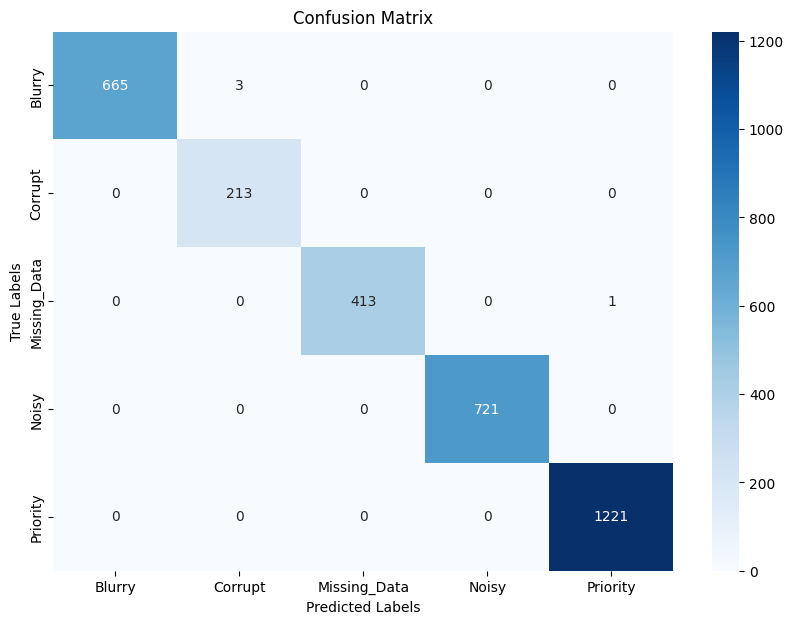

In [13]:
from evaluate import evaluate_pipeline
test_images = np.load('/shared/data/test_images1.npy')  # Load image val data
test_labels = np.load('/shared/data/test_labels.npy')
metrics = evaluate_pipeline(rf_model, test_images, test_labels, preprocess_dataset)

*Interpretation:* Evaluation Time (8.62 seconds): The model took 8.62 seconds to preprocess data and make predictions, which is fairly quick 

Peak Memory Usage (2912.21 MB): The model used up to 2.9 GB of memory, which is relatively high, and could be reduced for resource-constrained environments like CubeSats.

Average CPU Usage (619.94%): This indicates the model used around 6.2 CPU cores on average. For environments with limited CPU resources, optimizing the use of CPU cores would be beneficial.

Algorithm Code Size (1.82 MB): The model and preprocessing code are 1.82 MB, which is compact and ideal 

Accuracy (0.999): The model achieved a 99.9% accuracy, meaning it correctly classified almost all samples—an excellent result.

F1 Score (0.999): The F1 score of 0.999 indicates a great balance between precision and recall, especially important for imbalanced datasets.



#### **⚠️ Freeing up Space**

In [14]:
import gc

# Remove the data from memory
del train_images_pre, train_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data removed from memory.")

Data removed from memory.


In [15]:
# import os
# import sys

# # Restart the kernel programmatically to free up space
# os.execv(sys.executable, ['python'] + sys.argv)